In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/anndl-challenge/dataset_refined.npz


In [2]:
# Fix randomness and hide warnings
!pip install keras-cv
seed = 164

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf

from tensorflow import keras as tfk
from keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

# Import other libraries
import cv2
from keras.applications.efficientnet_v2 import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from PIL import Image
import pandas as pd
import keras_cv
import tensorflow_addons as tfa

2.13.0
Using TensorFlow backend


In [3]:
AUTO = tf.data.AUTOTUNE
RESIZE_TO = 96
CROP_TO = 72
EPOCHS = 200

In [4]:
data = np.load('/kaggle/input/anndl-challenge/dataset_refined.npz', allow_pickle=True)

images = data['arr_0']
labels = data['arr_1']
labels = np.array(labels)
images = np.array(images)

In [5]:
from imblearn.over_sampling import SMOTE

# Solve class imbalance using Smote
# Initialize Smote object
smote = SMOTE(sampling_strategy=0.75, random_state=seed)

# Flatten the images
images_flat = images.reshape(images.shape[0], -1)  # Reshape to (num_samples, num_features)

# Now you can use SMOTE on 'images_flat'
images_smote, labels_smote = smote.fit_resample(images_flat, labels)

# Now, 'images_smote' and 'labels_smote' contain the oversampled dataset
# Reshape the images
original_shape = (96, 96, 3)

images_original_shape = images_smote.reshape(-1, *original_shape)

In [6]:
# We need this for the next step
images_balanced = images_original_shape
labels_balanced = labels_smote

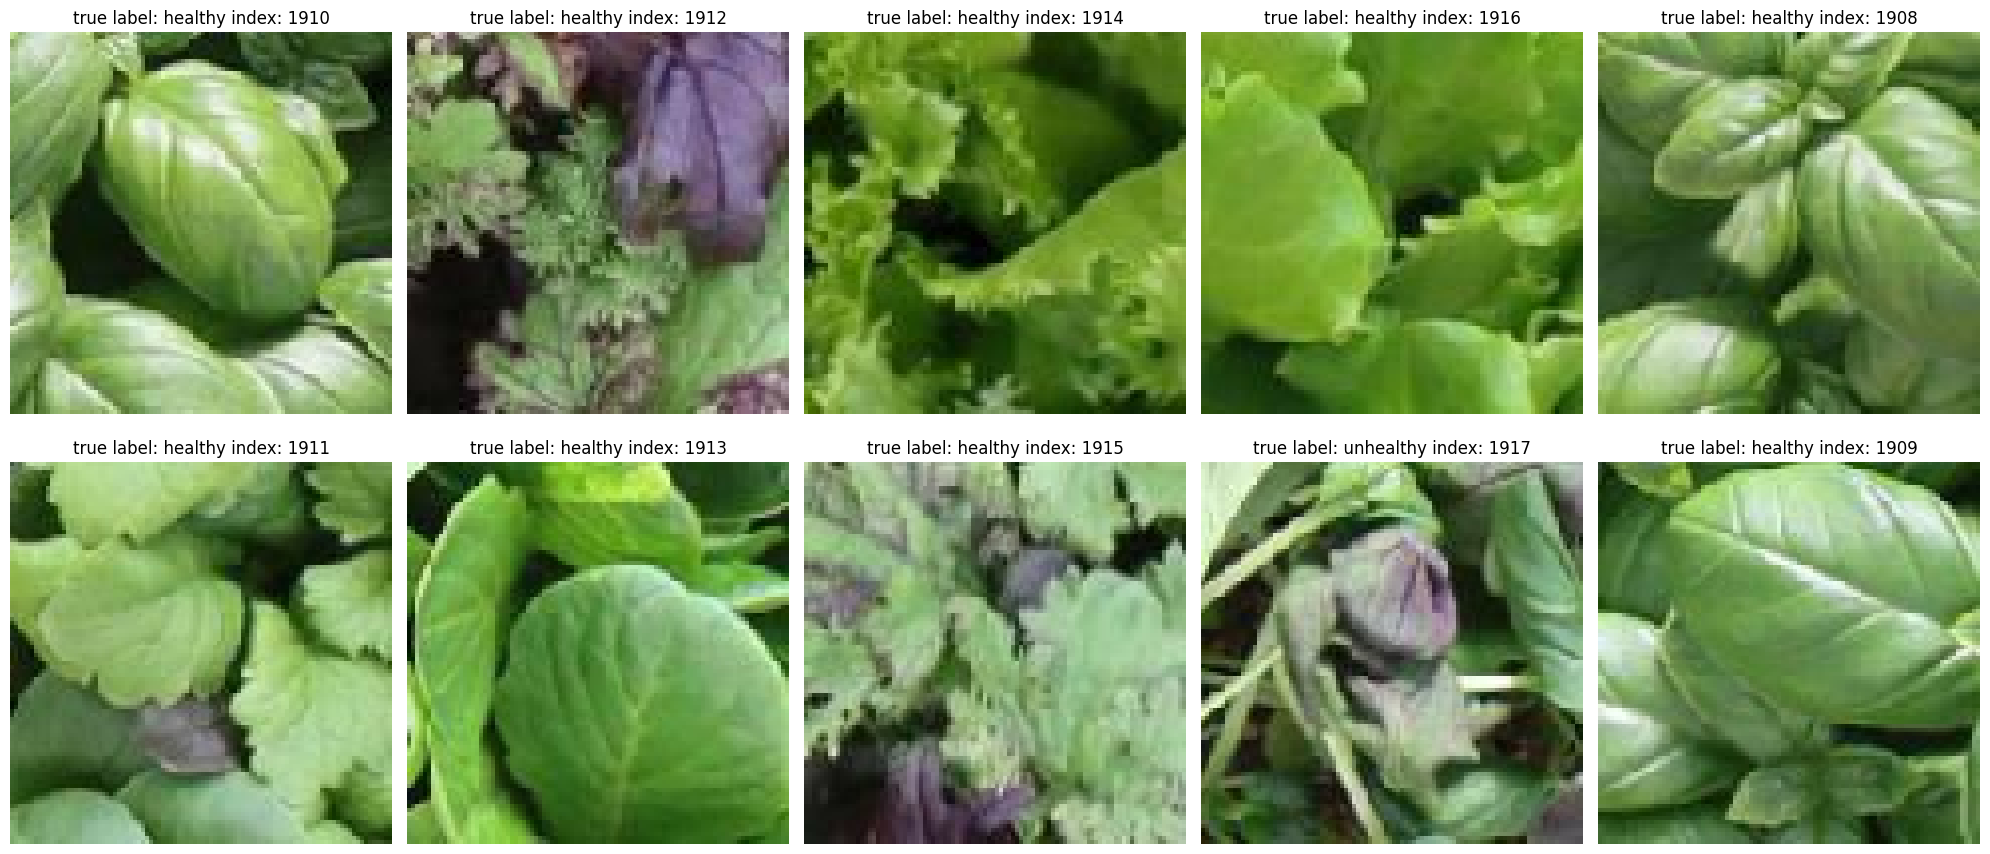

In [7]:
#Show the data
# Number of images to display
size = labels_balanced.size
num_img = 10
# Create a random index to display every time a different set of images
random_index = np.random.rand()
random_index = int(random_index*(size-num_img))

# Create subplots for displaying items
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(random_index, random_index + num_img):
    title = 'true label: ' + str(labels_balanced[i]) + ' index: ' + str(i)
    ax = axes[i%2, i%num_img//2]
    ax.set_title(title)
    ax.imshow(np.clip(images_balanced[i], 0, 255))  # Display clipped item images
    ax.axis('off')
plt.tight_layout()
plt.show()

In [8]:
#One-Hot Encoding
# Assuming 'labels_balanced' is a NumPy array containing your categorical labels
labels_onehot = labels_balanced  # Replace with your actual labels

# Get the unique categories in your label array
unique_categories = np.unique(labels_onehot)

# Initialize an empty array for one-hot encoded labels
one_hot_labels = np.zeros((len(labels_onehot), len(unique_categories)))

# Create one-hot encoded labels
for i, category in enumerate(unique_categories):
    one_hot_labels[:, i] = (labels_onehot == category).astype(int)

# Now, 'one_hot_labels' contains the one-hot encoded labels

labels_balanced_onehot = one_hot_labels

In [9]:
X = images_balanced
y = labels_balanced_onehot

# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=.10, stratify=np.argmax(y, axis=1))

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=.20, stratify=np.argmax(y_train_val, axis=1))




In [10]:
# Initialize the RandAugment layer from keras-cv
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=3,
    magnitude=0.3,
    magnitude_stddev=0.2,
    rate=0.5,
)

def apply_rand_augment(inputs):
    inputs = rand_augment(inputs)
    return inputs

In [11]:
# Function to preprocess the train set
def preprocess_train(image, label, noisy=True):
    # If the dataset has to be clean we just apply the preprocess thought for EfficientNet
    # and apply a random flip to the image and a random brightness
    image = preprocess_input(image*255)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.2)
    if noisy:
        # If the dataset is thought for the student we also apply RandAugment
        image = apply_rand_augment(image)
    return image, label

# Function to preprocess the test set
def preprocess_test(image, label):
    image = preprocess_input(image*255)
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [12]:
# This dataset will be used to train the first model.
train_clean_ds = (
    train_ds.shuffle(16 * 10, seed=42)
    .map(lambda x, y: (preprocess_train(x, y, noisy=False)), num_parallel_calls=AUTO)
    .batch(16)
    .prefetch(AUTO)
)

# This prepares the `Dataset` object to use RandAugment.
train_noisy_ds = (
    train_ds.shuffle(16 * 10, seed=42)
    .map(preprocess_train, num_parallel_calls=AUTO)
    .batch(16)
    .prefetch(AUTO)
)

validation_ds = (
    validation_ds.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(16)
    .prefetch(AUTO)
)

test_ds = (
    test_ds.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(16)
    .prefetch(AUTO)
)

# This dataset will be used to train the second model.
consistency_training_ds = tf.data.Dataset.zip((train_clean_ds, train_noisy_ds))

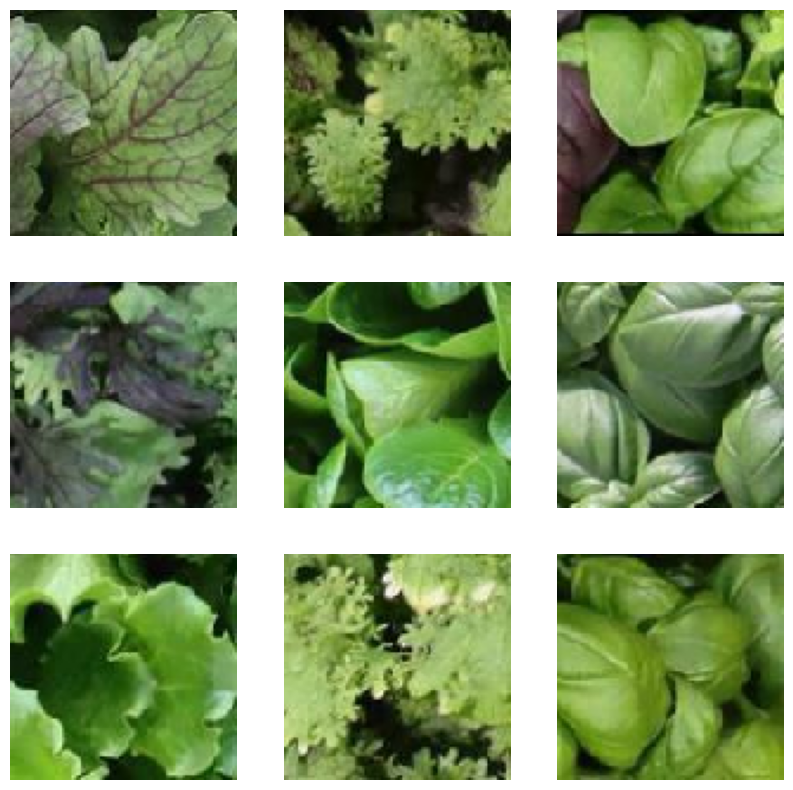

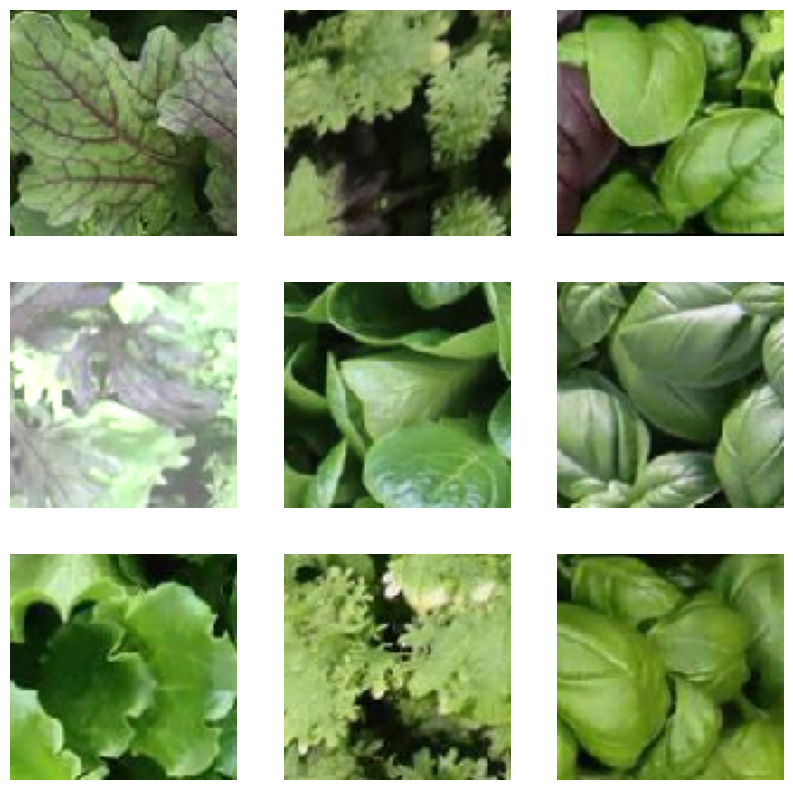

In [13]:
# Show images from both the clean and noisy dataset
sample_images, sample_labels = next(iter(train_clean_ds))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")

sample_images, sample_labels = next(iter(train_noisy_ds))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")

In [14]:
# Build the model
def get_training_model(num_classes=10):
    efficientnet_v2m = tf.keras.applications.EfficientNetV2M(
        weights='imagenet', include_top=False, input_shape=(96, 96, 3), pooling='avg', classes='2', classifier_activation= 'softmax'
    )
    model = tf.keras.Sequential(
        [
            tfk.layers.Input((96, 96, 3)),
            efficientnet_v2m,
            tfk.layers.Dense(720, activation='relu'),
            tfk.layers.BatchNormalization(epsilon=1e-06, momentum=0.9, weights=None),
            tfk.layers.Dense(360, activation = 'relu'),
            tfk.layers.Dropout(0.4),
            tfk.layers.Dense(2, activation='softmax'),
        ]
    )
    return model

In [15]:
# Define the callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3)
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

In [16]:
# Train the teacher model
teacher_model = get_training_model()
teacher_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

history = teacher_model.fit(
    train_clean_ds,
    epochs=EPOCHS,
    validation_data=validation_ds,
    callbacks=[reduce_lr, early_stopping],
)

214201816/214201816 [==============================] - 1s 0us/step
Epoch 1/200
241/241 [==============================] - 180s 167ms/step - loss: 1.1341 - accuracy: 0.5497 - val_loss: 3.2955 - val_accuracy: 0.5965 - lr: 0.0010
Epoch 2/200
241/241 [==============================] - 33s 138ms/step - loss: 0.9498 - accuracy: 0.5442 - val_loss: 2.6943 - val_accuracy: 0.4803 - lr: 0.0010
Epoch 3/200
241/241 [==============================] - 33s 139ms/step - loss: 0.8325 - accuracy: 0.5393 - val_loss: 0.7375 - val_accuracy: 0.5768 - lr: 0.0010
Epoch 4/200
241/241 [==============================] - 34s 139ms/step - loss: 0.6999 - accuracy: 0.5499 - val_loss: 0.6933 - val_accuracy: 0.5705 - lr: 0.0010
Epoch 5/200
241/241 [==============================] - 33s 138ms/step - loss: 0.6877 - accuracy: 0.5632 - val_loss: 0.6896 - val_accuracy: 0.6515 - lr: 0.0010
Epoch 6/200
241/241 [==============================] - 33s 138ms/step - loss: 0.6503 - accuracy: 0.6301 - val_loss: 0.6411 - val_accuracy

In [17]:
# Evaluate accuracy of the teacher model
_, acc = teacher_model.evaluate(test_ds, verbose=0)
print(f"Test accuracy: {acc*100}%")

Test accuracy: 77.42537260055542%


In [18]:
# Define the class SelfTrainer
class SelfTrainer(tf.keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.student = student
        self.teacher = teacher

    def compile(
        self, optimizer, metrics, student_loss_fn, distillation_loss_fn, temperature=3,
    ):
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.temperature = temperature

    def train_step(self, data):
        # Since our dataset is a zip of two independent datasets,
        # after initially parsing them, we segregate the
        # respective images and labels next.
        clean_ds, noisy_ds = data
        clean_images, _ = clean_ds
        noisy_images, y = noisy_ds

        # Forward pass of teacher
        teacher_predictions = self.teacher(clean_images, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(noisy_images, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            total_loss = (student_loss + distillation_loss) / 2

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`
        self.compiled_metrics.update_state(
            y, tf.nn.softmax(student_predictions, axis=1)
        )

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"total_loss": total_loss})
        return results
        

    def test_step(self, data):
        # During inference, we only pass a dataset consisting images and labels.
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Update the metrics
        self.compiled_metrics.update_state(y, tf.nn.softmax(y_prediction, axis=1))

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        return results

In [19]:
# Train the student
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    patience=3, factor=0.5, monitor="val_accuracy"
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True, monitor="val_accuracy"
)

selftrainer = SelfTrainer(student=get_training_model(), teacher=teacher_model)
selftrainer.compile(
        optimizer="adam",
        metrics=["accuracy"],
        student_loss_fn=tf.keras.losses.CategoricalCrossentropy(
            from_logits=True),
        distillation_loss_fn=tf.keras.losses.KLDivergence(),
        temperature=10,) 

history = selftrainer.fit(
    consistency_training_ds,
    epochs=EPOCHS,  
    validation_data=validation_ds,
    callbacks=[reduce_lr, early_stopping]
)

# Evaluate the student model
acc = selftrainer.evaluate(test_ds, verbose=0)
print(f"Test accuracy from student model: {acc*100}%")


Epoch 1/200
241/241 [==============================] - 181s 203ms/step - accuracy: 0.5556 - total_loss: 0.5737 - val_accuracy: 0.4658 - lr: 0.0010
Epoch 2/200
241/241 [==============================] - 43s 179ms/step - accuracy: 0.5699 - total_loss: 0.4577 - val_accuracy: 0.4990 - lr: 0.0010
Epoch 3/200
241/241 [==============================] - 45s 185ms/step - accuracy: 0.5367 - total_loss: 0.4024 - val_accuracy: 0.5405 - lr: 0.0010
Epoch 4/200
241/241 [==============================] - 45s 186ms/step - accuracy: 0.5492 - total_loss: 0.3523 - val_accuracy: 0.6110 - lr: 0.0010
Epoch 5/200
241/241 [==============================] - 44s 183ms/step - accuracy: 0.5450 - total_loss: 0.3483 - val_accuracy: 0.5705 - lr: 0.0010
Epoch 6/200
241/241 [==============================] - 45s 184ms/step - accuracy: 0.5907 - total_loss: 0.3417 - val_accuracy: 0.6307 - lr: 0.0010
Epoch 7/200
241/241 [==============================] - 43s 178ms/step - accuracy: 0.5912 - total_loss: 0.3389 - val_accurac

In [20]:
# Save the weights of the models
selftrainer.student.save_weights("/kaggle/working/student_noisy_ma.h5")
teacher_model.save_weights("/kaggle/working/teacher_model_ma.h5")

In [21]:
# Save the student model
student_noisy_ma = get_training_model()
student_noisy_ma.load_weights("/kaggle/working/student_noisy_ma.h5")
student_noisy_ma.compile(loss="categorical_crossentropy",
                         metrics=["accuracy"])
student_noisy_ma.save('/kaggle/working/studentModel')

In [22]:
# Evaluate the accuracy of the student model
student_noisy_ma.evaluate(test_ds)

34/34 [==============================] - 7s 39ms/step - loss: 0.4415 - accuracy: 0.8153


[0.44148409366607666, 0.8152984976768494]